<a href="https://colab.research.google.com/github/fibsouza/Bootcamp-data-analysis/blob/master/shelter_animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução 

Falar algo que ache relevante sobre o dataset ...

Tentaremos prever a possibilidade de um animal ser Adotado, Transferido, Sofrer Eutanásia, Voltar para o dono ou Morrer. Nossa classe target é a coluna OutcomeType.

# Configuração de ambiente

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastaai_utils import add_datepart,train_cats, proc_df
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss,f1_score
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/data/shelter_animal'
shelter_train = pd.read_csv(path+'/train.csv', engine='python')
shelter_test = pd.read_csv(path+'/test.csv', engine='python')

# Exploração dos dados

In [ ]:
#Note que o dataset de treino contém a coluna OutcomeType, lembre-se de retira-la no treino

shelter_train.tail().T

,26724,26725,26726,26727,26728
AnimalID,A702446,A718934,A698128,A677478,A706629
Name,NaN,NaN,Zeus,NaN,NaN
DateTime,2015-05-14 11:56:00,2016-01-20 18:59:00,2015-03-09 13:33:00,2014-04-27 12:22:00,2015-07-02 09:00:00
OutcomeType,Transfer,Transfer,Adoption,Transfer,Transfer
OutcomeSubtype,Partner,SCRP,NaN,Partner,SCRP
AnimalType,Cat,Cat,Dog,Cat,Cat
SexuponOutcome,Intact Male,Spayed Female,Neutered Male,Intact Male,Intact Male
AgeuponOutcome,1 month,3 months,4 years,4 weeks,1 year
Breed,Domestic Shorthair Mix,Domestic Shorthair Mix,Old English Bulldog Mix,Domestic Shorthair Mix,Domestic Shorthair Mix
Color,Brown Tabby/White,Brown Tabby,White/Tan,Black,Brown Tabby/White


In [ ]:
#Note que o dataset de teste nao vem com a coluna OutcomeType

shelter_test.tail().T

,11451,11452,11453,11454,11455
ID,11452,11453,11454,11455,11456
Name,NaN,NaN,NaN,Rambo,Gusto
DateTime,2014-07-08 14:50:00,2014-10-21 12:57:00,2014-09-29 09:00:00,2015-09-05 17:16:00,2014-07-12 18:40:00
AnimalType,Cat,Cat,Cat,Dog,Dog
SexuponOutcome,Neutered Male,Intact Female,Intact Female,Neutered Male,Intact Male
AgeuponOutcome,2 months,2 weeks,1 year,6 years,4 years
Breed,Domestic Shorthair Mix,Domestic Shorthair Mix,Domestic Shorthair Mix,German Shepherd Mix,Labrador Retriever
Color,Black,Blue,Calico,Black/Tan,Cream


In [ ]:
shelter_test.index

RangeIndex(start=0, stop=11456, step=1)

In [ ]:
#COLUNAS PRESENTES NO DATASET TREINO x TREINO
shelter_train.columns,  shelter_test.columns, 

(Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
        'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
       dtype='object'),
 Index(['ID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome',
        'AgeuponOutcome', 'Breed', 'Color'],
       dtype='object'))

In [ ]:
#QUANTIDADE DE LINHAS TREINO X TESTE

len(shelter_train), len(shelter_test)

(26729, 11456)

Text(0.5, 1.0, 'Situacao dos animais em abrigos')

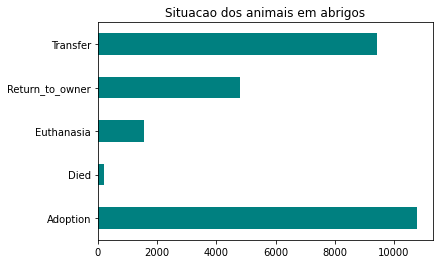

In [ ]:
#VER BALANCEAMENTO DAS CLASSES : TREINO

shelter_train['OutcomeType'].value_counts().sort_index().plot(kind='barh', color='teal')
plt.title('Situacao dos animais em abrigos')

In [ ]:
#CONCATENAR TREINO E TESTE

shelter_ALL = pd.concat([shelter_train, shelter_test], axis=0).reset_index()  #concatenar dois dataframes 
len(shelter_ALL) 

38185

In [ ]:
shelter_ALL.dtypes

index               int64
AnimalID           object
Name               object
DateTime           object
OutcomeType        object
OutcomeSubtype     object
AnimalType         object
SexuponOutcome     object
AgeuponOutcome     object
Breed              object
Color              object
ID                float64
dtype: object

In [ ]:
def discover(data):
  print('Coluna | Type | NaN | Nulo')
  for k,v in data.items():
    print(k , v.dtype, v.isna().sum(), v.isnull().sum())

In [ ]:
discover(shelter_ALL)

Coluna | Type | NaN | Nulo
index int64 0 0
AnimalID object 11456 11456
Name object 10916 10916
DateTime object 0 0
OutcomeType object 11456 11456
OutcomeSubtype object 25068 25068
AnimalType object 0 0
SexuponOutcome object 1 1
AgeuponOutcome object 24 24
Breed object 0 0
Color object 0 0
ID float64 26729 26729




---



# Tratamento de colunas 

In [ ]:
len(shelter_ALL)

38185

## 1) Campo DateTime

In [ ]:
add_datepart(shelter_ALL, 'DateTime')
shelter_ALL.tail()

,index,AnimalID,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID,DateTimeYear,DateTimeMonth,DateTimeWeek,DateTimeDay,DateTimeDayofweek,DateTimeDayofyear,DateTimeIs_month_end,DateTimeIs_month_start,DateTimeIs_quarter_end,DateTimeIs_quarter_start,DateTimeIs_year_end,DateTimeIs_year_start,DateTimeElapsed
38180,11451,NaN,NaN,NaN,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,11452.0,2014,7,28,8,1,189,False,False,False,False,False,False,1404831000
38181,11452,NaN,NaN,NaN,NaN,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue,11453.0,2014,10,43,21,1,294,False,False,False,False,False,False,1413896220
38182,11453,NaN,NaN,NaN,NaN,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico,11454.0,2014,9,40,29,0,272,False,False,False,False,False,False,1411981200
38183,11454,NaN,Rambo,NaN,NaN,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan,11455.0,2015,9,36,5,5,248,False,False,False,False,False,False,1441473360
38184,11455,NaN,Gusto,NaN,NaN,Dog,Intact Male,4 years,Labrador Retriever,Cream,11456.0,2014,7,28,12,5,193,False,False,False,False,False,False,1405190400


## 2) Campo Idade

In [ ]:
shelter_ALL[(shelter_ALL['AgeuponOutcome'].isna())]

,index,AnimalID,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID,DateTimeYear,DateTimeMonth,DateTimeWeek,DateTimeDay,DateTimeDayofweek,DateTimeDayofyear,DateTimeIs_month_end,DateTimeIs_month_start,DateTimeIs_quarter_end,DateTimeIs_quarter_start,DateTimeIs_year_end,DateTimeIs_year_start,DateTimeElapsed
2480,2480,A720674,NaN,Transfer,SCRP,Cat,Intact Male,NaN,Domestic Shorthair Mix,Blue Tabby/White,NaN,2016,2,7,16,1,47,False,False,False,False,False,False,1455617820
2912,2912,A720973,NaN,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Gray Tabby,NaN,2016,2,7,18,3,49,False,False,False,False,False,False,1455822420
3766,3766,A720820,NaN,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Brown Tabby,NaN,2016,2,7,16,1,47,False,False,False,False,False,False,1455648900
3875,3875,A721076,NaN,Euthanasia,Suffering,Dog,Intact Male,NaN,Toy Poodle Mix,White,NaN,2016,2,7,20,5,51,False,False,False,False,False,False,1455986220
4498,4498,A720422,NaN,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Brown Tabby,NaN,2016,2,6,9,1,40,False,False,False,False,False,False,1455046980
5137,5137,A720697,NaN,Transfer,SCRP,Cat,Spayed Female,NaN,Domestic Shorthair Mix,Black,NaN,2016,2,7,16,1,47,False,False,False,False,False,False,1455617820
5691,5691,A720640,NaN,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Black Tabby/White,NaN,2016,2,7,16,1,47,False,False,False,False,False,False,1455617820
7005,7005,A720636,NaN,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Black,NaN,2016,2,7,16,1,47,False,False,False,False,False,False,1455617820
8420,8420,A720701,NaN,Transfer,SCRP,Cat,Intact Male,NaN,Domestic Shorthair Mix,Blue Tabby/White,NaN,2016,2,7,16,1,47,False,False,False,False,False,False,1455617760
17464,17464,A720782,NaN,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Torbie,NaN,2016,2,7,16,1,47,False,False,False,False,False,False,1455648900


In [ ]:
shelter_ALL['AgeuponOutcome'].fillna('0 day', inplace=True)

In [ ]:
def age_converter(x): 

    [age, unit] = x.split(' ', 1)
    #print(age,unit)

    if('day' in unit):
        if age=='0': return 1
        return int(age)
    if('week' in unit):
        if(age)=='0': return 7
        return int(age)*7
    elif('month' in unit):
        if(age)=='0': return 30
        return int(age) * 4*7
    elif('year' in unit):
        if(age)=='0': return 365
        return int(age) * 4*12*7
    

In [ ]:
shelter_ALL['AgeuponOutcome']

0          1 year
1          1 year
2         2 years
3         3 weeks
4         2 years
           ...   
38180    2 months
38181     2 weeks
38182      1 year
38183     6 years
38184     4 years
Name: AgeuponOutcome, Length: 38185, dtype: object

In [ ]:
shelter_ALL['AgeInDays']  = shelter_ALL['AgeuponOutcome'].apply(age_converter)

shelter_ALL['AgeInDays']

0         336
1         336
2         672
3          21
4         672
         ... 
38180      56
38181      14
38182     336
38183    2016
38184    1344
Name: AgeInDays, Length: 38185, dtype: int64

## 3) Separação de listas em dados colunas únicas

In [ ]:
#Separacao das cores
shelter_ALL = shelter_ALL.join(shelter_ALL['Color'].str.split('/', 1, expand=True).rename(columns={0:'Color_0', 1:'Color_1'}))

In [ ]:
#Separacao da coluna sexo
shelter_ALL = shelter_ALL.join(shelter_ALL['SexuponOutcome'].str.split(' ', 1, expand=True).rename(columns={0:'SexuponOutcome_0', 1:'SexuponOutcome_1'}))

In [ ]:
#Separacao da coluna raça
shelter_ALL =shelter_ALL.join(shelter_ALL['Breed'].str.split(' ', -1, expand=True).rename(columns={0:'Breed_0', 1:'Breed_1', 2:'Breed_2', 3:'Breed_3', 4:'Breed_4', 5:'Breed_5'}))

## 4) Criando novas colunas

In [ ]:
shelter_ALL['Multi_Colors'] = shelter_ALL['Color'].apply(lambda x : True if '/' in x else False)

In [ ]:
shelter_ALL['Mixed'] = shelter_ALL['Breed'].apply(lambda x : True if 'Mix' in x else False)

In [ ]:
shelter_ALL['Name'] = shelter_ALL['Name'].fillna(value=0)

In [ ]:
shelter_ALL['Is_Named'] = shelter_ALL['Name'].apply(lambda x : True if x is not 0 else False)

## 2) Nulos e NaN

In [ ]:
def tratarString(data):
  for k,v in data.items():
    if not is_numeric_dtype(v):
      data[k].fillna('Unknown', inplace=True)

In [ ]:
tratarString(shelter_ALL)

## 4) Categoricos

In [ ]:
#Campos do tipo string devem virar categoricas
def paraCategorico(data):
  for k,v in data.items():
    if is_string_dtype(v):
      data[k] = v.astype('category').cat.as_ordered()

In [ ]:
paraCategorico(shelter_ALL)

## 5) Numericos

In [ ]:
def paraNumerico(data):
  for k,v in data.items():
    if not is_numeric_dtype(v):
      data[k] = data[k].cat.codes

In [ ]:
paraNumerico(shelter_ALL)



---



# Separar Treino e Teste

In [ ]:
shelter_ALL.head()

,index,AnimalID,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID,DateTimeYear,DateTimeMonth,DateTimeWeek,DateTimeDay,DateTimeDayofweek,DateTimeDayofyear,DateTimeIs_month_end,DateTimeIs_month_start,DateTimeIs_quarter_end,DateTimeIs_quarter_start,DateTimeIs_year_end,DateTimeIs_year_start,DateTimeElapsed,AgeInDays,Color_0,Color_1,SexuponOutcome_0,SexuponOutcome_1,Breed_0,Breed_1,Breed_2,Breed_3,Breed_4,Breed_5,6,Multi_Colors,Mixed,Is_Named
0,0,5419,2911,3,16,1,2,6,1482,146,NaN,2014,2,7,12,2,43,False,False,False,False,False,False,1392229320,336,15,44,1,1,399,495,123,65,21,4,1,True,True,True
1,1,1603,2266,2,15,0,3,6,775,184,NaN,2013,10,41,13,6,286,False,False,False,False,False,False,1381668240,336,26,43,2,0,207,550,123,65,21,4,1,False,True,True
2,2,11613,5501,0,6,1,2,22,1293,97,NaN,2015,1,5,31,5,31,True,False,False,False,False,False,1422707280,672,7,44,1,1,327,20,123,65,21,4,1,True,True,True
3,3,10238,0,4,12,0,1,27,775,47,NaN,2014,7,28,11,4,192,False,False,False,False,False,False,1405105740,21,8,43,0,1,207,550,123,65,21,4,1,False,True,False
4,4,3501,0,4,12,1,2,22,1101,311,NaN,2013,11,46,15,4,319,False,False,False,False,False,False,1384519920,672,49,43,1,1,254,7,133,65,21,4,1,False,False,False


In [ ]:
shelter_ALL 

,index,AnimalID,Name,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID,DateTimeYear,DateTimeMonth,DateTimeWeek,DateTimeDay,DateTimeDayofweek,DateTimeDayofyear,DateTimeIs_month_end,DateTimeIs_month_start,DateTimeIs_quarter_end,DateTimeIs_quarter_start,DateTimeIs_year_end,DateTimeIs_year_start,DateTimeElapsed,AgeInDays,Color_0,Color_1,SexuponOutcome_0,SexuponOutcome_1,Breed_0,Breed_1,Breed_2,Breed_3,Breed_4,Breed_5,6,Multi_Colors,Mixed,Is_Named
0,0,5419,2911,3,16,1,2,6,1482,146,NaN,2014,2,7,12,2,43,False,False,False,False,False,False,1392229320,336,15,44,1,1,399,495,123,65,21,4,1,True,True,True
1,1,1603,2266,2,15,0,3,6,775,184,NaN,2013,10,41,13,6,286,False,False,False,False,False,False,1381668240,336,26,43,2,0,207,550,123,65,21,4,1,False,True,True
2,2,11613,5501,0,6,1,2,22,1293,97,NaN,2015,1,5,31,5,31,True,False,False,False,False,False,1422707280,672,7,44,1,1,327,20,123,65,21,4,1,True,True,True
3,3,10238,0,4,12,0,1,27,775,47,NaN,2014,7,28,11,4,192,False,False,False,False,False,False,1405105740,21,8,43,0,1,207,550,123,65,21,4,1,False,True,False
4,4,3501,0,4,12,1,2,22,1101,311,NaN,2013,11,46,15,4,319,False,False,False,False,False,False,1384519920,672,49,43,1,1,254,7,133,65,21,4,1,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38180,11451,26729,0,5,16,0,2,20,775,6,11452.0,2014,7,28,8,1,189,False,False,False,False,False,False,1404831000,56,2,43,1,1,207,550,123,65,21,4,1,False,True,False
38181,11452,26729,0,5,16,0,0,21,775,46,11453.0,2014,10,43,21,1,294,False,False,False,False,False,False,1413896220,14,7,43,0,0,207,550,123,65,21,4,1,False,True,False
38182,11453,26729,0,5,16,0,0,6,775,156,11454.0,2014,9,40,29,0,272,False,False,False,False,False,False,1411981200,336,21,43,0,0,207,550,123,65,21,4,1,False,True,False
38183,11454,26729,5965,5,16,1,2,39,841,40,11455.0,2015,9,36,5,5,248,False,False,False,False,False,False,1441473360,2016,2,39,1,1,219,506,123,65,21,4,1,True,True,True


In [ ]:
shelter_ALL.columns

Index([                   'index',                 'AnimalID',
                           'Name',              'OutcomeType',
                 'OutcomeSubtype',               'AnimalType',
                 'SexuponOutcome',           'AgeuponOutcome',
                          'Breed',                    'Color',
                             'ID',             'DateTimeYear',
                  'DateTimeMonth',             'DateTimeWeek',
                    'DateTimeDay',        'DateTimeDayofweek',
              'DateTimeDayofyear',     'DateTimeIs_month_end',
         'DateTimeIs_month_start',   'DateTimeIs_quarter_end',
       'DateTimeIs_quarter_start',      'DateTimeIs_year_end',
          'DateTimeIs_year_start',          'DateTimeElapsed',
                      'AgeInDays',                  'Color_0',
                        'Color_1',         'SexuponOutcome_0',
               'SexuponOutcome_1',                  'Breed_0',
                        'Breed_1',                  'Br

In [ ]:
filtro_colunas_1 = shelter_ALL.columns.difference(['6','ID','index','AnimalID', 'OutcomeType','OutcomeSubtype', 'Name', 'SexuponOutcome','AgeuponOutcome', 'Breed','Color'])
filtro_colunas_2 = shelter_ALL.columns.difference(['6','ID','index','AnimalID', 'Name', 'AgeuponOutcome','SexuponOutcome', 'Breed','Color'])


In [ ]:
X = shelter_ALL[filtro_colunas_1]

In [ ]:
#PARA SEPARAR O TREINO DO TESTE NOVAMENTE , INDEX 26729 EM DIANTE É TESTE
#É PRA FAZER APOS TRATAR TODAS AS COLUNAS 
X_train = X.loc[:26728]
X_test = X.loc[26729:]
y_train = shelter_ALL['OutcomeType'].loc[:26728]
y_test = shelter_ALL['OutcomeType'].loc[26729:]

# Primeira Correlação das colunas

Obs.: Fazer com todos os dados (shelter_ALL), depois com a separacao treino , desta segunda vez apos treino do modelo 

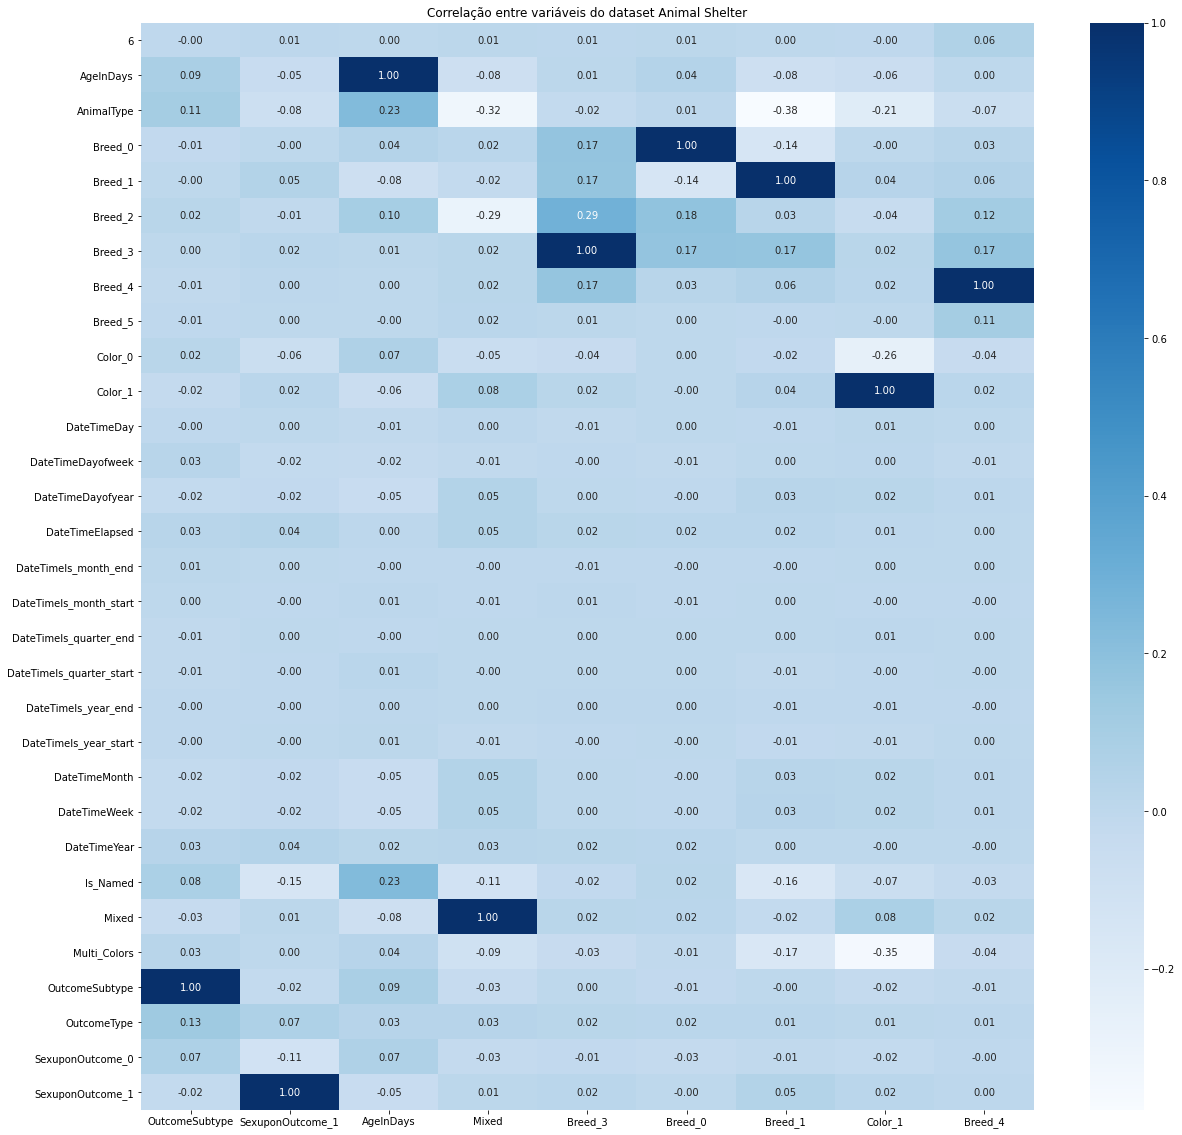

In [ ]:
correlacao = shelter_ALL[filtro_colunas_2].corr()

top_cols = correlacao.nlargest(10,'OutcomeType')['OutcomeType'].index

plt.figure(figsize=(20, 20))
sns.heatmap(correlacao[top_cols[1:]],
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis do dataset Animal Shelter')
plt.show()

In [ ]:
top_cols[2:]

Index(['SexuponOutcome_1', 'AgeInDays', 'Mixed', 'Breed_3', 'Breed_0',
       'Breed_1', 'Color_1', 'Breed_4'],
      dtype='object')

# Treinamento do modelo

In [ ]:
classifier_forest = RandomForestClassifier(bootstrap=False, criterion='gini', 
                                           max_depth=5, max_features=0.3,n_estimators=50,n_jobs=-1)
  #random_state=1922, criterion='gini', max_depth=10, n_estimators=50, n_jobs=-1
 
classifier_forest.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

<function matplotlib.pyplot.show>

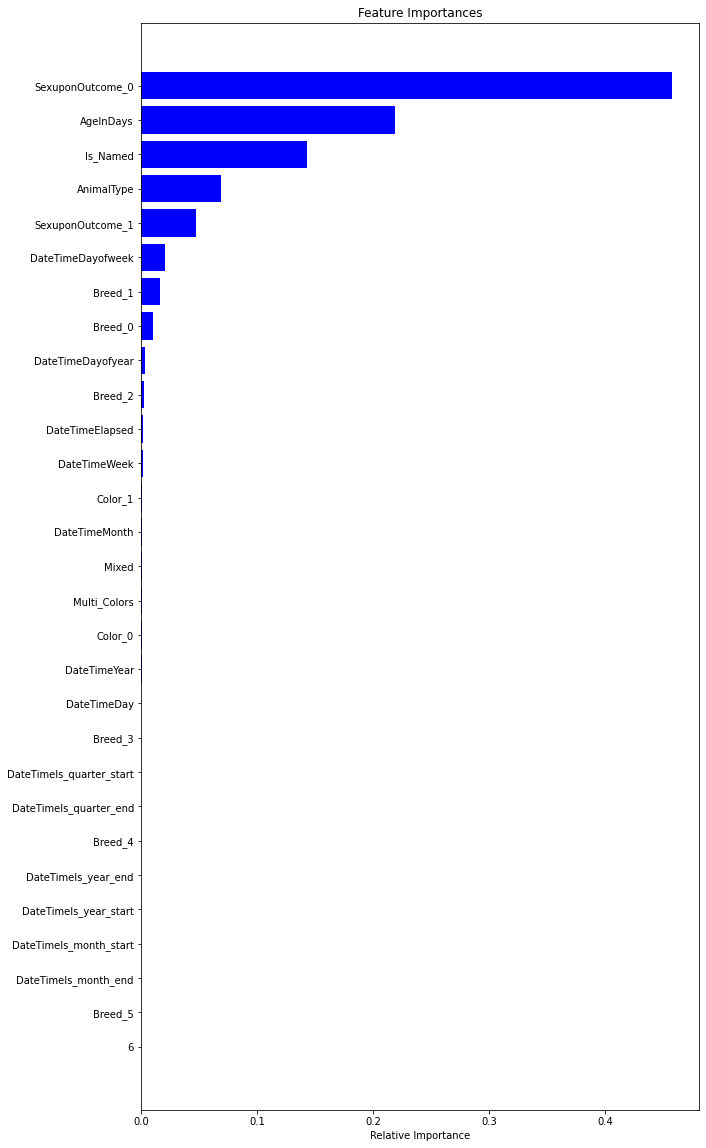

In [ ]:
import numpy as np
features= filtro_colunas_1
importances = classifier_forest.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show

In [ ]:
y_pred = classifier_forest.predict(X_test)
classifier_forest.score(X_test,y_)
y_pred

array([4, 0, 0, ..., 4, 0, 3], dtype=int8)

In [ ]:
y_pred_proba = classifier_forest.predict_proba(X_test)
y_pred_proba

array([[0.12717224, 0.01025861, 0.09490404, 0.26745979, 0.50020532],
       [0.51707148, 0.00157198, 0.03177004, 0.29420816, 0.15537834],
       [0.4722743 , 0.00395233, 0.03676925, 0.17703468, 0.30996944],
       ...,
       [0.045969  , 0.01944838, 0.12624835, 0.0105711 , 0.79776317],
       [0.46293189, 0.00164612, 0.03733848, 0.34399166, 0.15409185],
       [0.14123131, 0.00455946, 0.12980431, 0.36877699, 0.35562794]])

In [ ]:
y = y_pred_proba.max(axis=1)
y

array([0.50020532, 0.51707148, 0.4722743 , ..., 0.79776317, 0.46293189,
       0.36877699])

In [ ]:
df_results =  pd.DataFrame(y_pred_proba, columns=classifier_forest.classes_)
df_results

,0,1,2,3,4
0,0.127172,0.010259,0.094904,0.267460,0.500205
1,0.517071,0.001572,0.031770,0.294208,0.155378
2,0.472274,0.003952,0.036769,0.177035,0.309969
3,0.183449,0.012067,0.055662,0.159267,0.589555
4,0.405329,0.001911,0.044688,0.353661,0.194411
...,...,...,...,...,...
11451,0.650282,0.005418,0.041716,0.033443,0.269141
11452,0.015593,0.019408,0.065532,0.004594,0.894873
11453,0.045969,0.019448,0.126248,0.010571,0.797763
11454,0.462932,0.001646,0.037338,0.343992,0.154092


In [ ]:
df_results.rename(columns={0:'Adoption',1:'Died',	2:'Euthanasia',3:'Return_to_owner',4:'Transfer'}, inplace=True)

In [ ]:
df_results

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,0.127172,0.010259,0.094904,0.267460,0.500205
1,0.517071,0.001572,0.031770,0.294208,0.155378
2,0.472274,0.003952,0.036769,0.177035,0.309969
3,0.183449,0.012067,0.055662,0.159267,0.589555
4,0.405329,0.001911,0.044688,0.353661,0.194411
...,...,...,...,...,...
11451,0.650282,0.005418,0.041716,0.033443,0.269141
11452,0.015593,0.019408,0.065532,0.004594,0.894873
11453,0.045969,0.019448,0.126248,0.010571,0.797763
11454,0.462932,0.001646,0.037338,0.343992,0.154092


In [ ]:
df_results.describe()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
count,11456.000000,11456.000000,11456.000000,11456.000000,11456.000000
mean,0.407663,0.007230,0.057386,0.178959,0.348762
std,0.234595,0.008876,0.047769,0.128956,0.239904
min,0.007333,0.000684,0.009251,0.004395,0.127855
25%,0.159098,0.001832,0.029053,0.052544,0.186885
50%,0.451850,0.002441,0.042994,0.169658,0.213974
75%,0.577884,0.008883,0.067583,0.311174,0.456183
max,0.818058,0.191085,0.392589,0.430185,0.910694


In [ ]:
#score_forest = cross_val_score(classifier_forest, X_train, y_train, scoring='f1_macro', cv=5)
#print(score_forest.mean())

#score_forest = f1_score(y_train[:11456], y_pred, average='weighted')
#print(score_forest)

# Segunda Correlação das colunas

Obs.: Fazer com todos os dados (shelter_ALL), depois com a separacao treino , ambas as vezes apos treino do modelo 

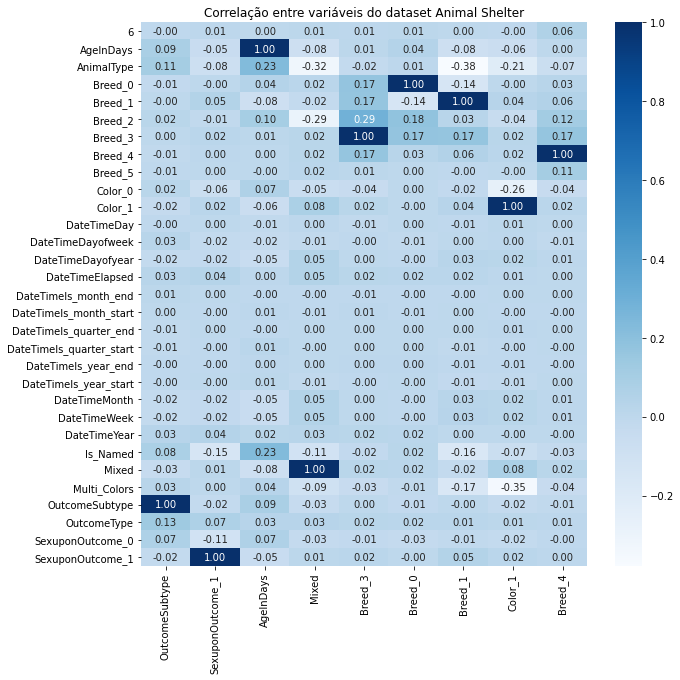

In [ ]:
correlacao = shelter_ALL[filtro_colunas_2].corr()

top_cols = correlacao.nlargest(10,'OutcomeType')['OutcomeType'].index

plt.figure(figsize=(10, 10))
sns.heatmap(correlacao[top_cols[1:]],
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis do dataset Animal Shelter')
plt.show()

In [ ]:
"""param_grid = {
            "criterion": ['entropy', 'gini'],
            "n_estimators": [25, 50, 75],
            "bootstrap": [False, True],
            "max_depth": [3, 5, 10],
            "max_features": ['auto', 0.1, 0.2, 0.3]
}"""

'param_grid = {\n            "criterion": [\'entropy\', \'gini\'],\n            "n_estimators": [25, 50, 75],\n            "bootstrap": [False, True],\n            "max_depth": [3, 5, 10],\n            "max_features": [\'auto\', 0.1, 0.2, 0.3]\n}'

In [ ]:
"""grid_search = GridSearchCV(classifier_forest, param_grid, scoring='f1_macro')
grid_search.fit(X_train, y_train)

classifier_forest = grid_search.best_estimator_ 
grid_search.best_params_, grid_search.best_score_"""

"grid_search = GridSearchCV(classifier_forest, param_grid, scoring='f1_macro')\ngrid_search.fit(X_train, y_train)\n\nclassifier_forest = grid_search.best_estimator_ \ngrid_search.best_params_, grid_search.best_score_"